TODO:
    siflis
    HIV tratamento e controle
    grupos proximos: idade
    taxas de crescimento
    
ideia: baseado em um modelo SIR calcular o valor esperado de numero de contaminados em 2018. 
A diferença entre o valor esperado e o atual seria 

In [185]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

plt.rcParams["figure.figsize"] = [4,3]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
pd.set_option('display.max_columns', 500)
sns.set_style("whitegrid")
plt.style.use('./graph_config.mplstyle')

HET_COLOR = "#00A4CCFF"# "#00A4CCFF"
GAY_COLOR = "#F95700FF" # "#F95700FF"
palette_hetgay = [HET_COLOR,GAY_COLOR]
order_hetgay = ["Heterossexual","Gay"]

SINGLE_COLOR="#b3c6ff"

#### useful functions

In [135]:
def melt_groups(df, cols):
    # Example: melt_groups(cases, ["hiv_m","hiv_f"])
    return (df.melt(id_vars=["name","code","year","treated"],
               value_vars=cols,
               var_name="group")
          .rename(columns={"variable":"code",
                           "value":"cases"}))

def binned_data(df, var, dict_hist):
    labels = []
    values = []
    for label,interval in dict_hist.items():
        start = interval[0]
        end = interval[1]
        query = f"{var} >= {start} & {var} <= {end}"
        labels.append(label)
        value = graph_hist_grouped[label] = df.query(query).shape[0]
        values.append(value)

    return pd.DataFrame({"labels":labels, "values":values})

#### outcome variable

##### cities

In [3]:
cases = pd.read_csv("data/cases_cleaned.csv")
cases = cases.query("region_type == 'city' ")
cases = cases.sort_values(['code','year'])
cases = cases.set_index(['code','year','name'])

def pct_change_2(series):
    return series.pct_change(2)

outcomes = (cases
            #.set_index(['code','year','name'])
    .groupby(["code","year"])
    .agg({"hiv_total": "pct_change",
          "hep_b_total":"pct_change",
          "hep_b_m":"pct_change",
          "hep_b_f":"pct_change",
          "hiv_homo":"pct_change",
          "hiv_het":"pct_change",
          "hiv_f":"pct_change"}))

outcomes = outcomes.add_suffix('_pct_change')
cases = pd.concat([cases, outcomes], axis=1).reset_index().set_index("code")

cases["hiv_het_pct_change_follow_year"] = cases.shift(-1)["hiv_het_pct_change"]
cases["hiv_homo_pct_change_follow_year"] = cases.shift(-1)["hiv_homo_pct_change"]

##### regions

In [4]:
regions = pd.read_csv("data/regions.csv")

regions = regions.set_index(['region_code','year','region_name'])
outcomes_region = (regions
            #.set_index(['code','year','name'])
        .groupby("region_code")
        .agg({
             "hiv_total":"pct_change",
             "hiv_homo":"pct_change",
             "hiv_het":"pct_change",
             "hiv_bi":"pct_change",
             "hiv_f":"pct_change",
             "hep_b_total":"pct_change",
             "hep_b_m":"pct_change",
             "hep_b_f":"pct_change",
             "following":"pct_change",
             "loss_of_follow":"pct_change",
             "new_users":"pct_change"
})
)

#### barplot count gay x het

/tmp/ipykernel_475/1332565531.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


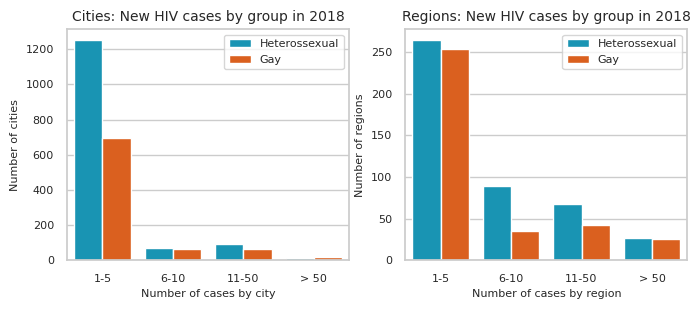

In [188]:
dict_hist = {
    "1-5":  [1,5],
    "6-10": [6,10],
    "11-50":[11,50],
    "> 50": [50,100000]
}

het_count_hist = binned_data(cases.query("year == 2018"), "hiv_het", dict_hist)
gay_count_hist = binned_data(cases.query("year == 2018"), "hiv_homo", dict_hist)

het_count_hist["group"] = "Heterossexual"
gay_count_hist["group"] = "Gay"

hist_count = pd.concat([het_count_hist, gay_count_hist])

##### CITIES

fig, ax = plt.subplots(figsize=(8,3))
plt.subplot(1, 2, 1)
g = sns.barplot(hist_count,
             x="labels", y="values", hue="group",
                palette=palette_hetgay,
                hue_order=order_hetgay)

plt.title("Cities: New HIV cases by group in 2018",fontsize=10)
sns.move_legend(g, "upper right", title="",fontsize=8)
plt.ylabel("Number of cities")
plt.xlabel("Number of cases by city")


##### REGION

plt.subplot(1, 2, 2)
het_count_hist = binned_data(regions.query("year == 2018"), "hiv_het", dict_hist)
gay_count_hist = binned_data(regions.query("year == 2018"), "hiv_homo", dict_hist)

het_count_hist["group"] = "Heterossexual"
gay_count_hist["group"] = "Gay"

hist_count = pd.concat([het_count_hist, gay_count_hist])

#fig, ax = plt.subplots(figsize=(20,10))
g = sns.barplot(hist_count,
             x="labels", y="values", hue="group",
             palette=palette_hetgay,
             hue_order=order_hetgay)

plt.title("Regions: New HIV cases by group in 2018",fontsize=10)
sns.move_legend(g, "upper right", title="",fontsize=8)
plt.ylabel("Number of regions")
plt.xlabel(f"Number of cases by region")

plt.savefig("results_graphs/new_cases_by_city_region.png", 
               bbox_inches='tight')
plt.show()

#### New users by year

In [192]:
cases.query("year in [2018,2019,2020,2021]").groupby("year")[["following","hiv_total"]].sum()

,following,hiv_total
year,,
2018,6420.0,38611
2019,12803.0,38310
2020,18682.0,30625
2021,30298.0,35228


/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


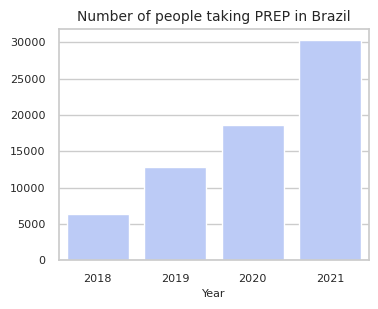

In [186]:
from numpy import count_nonzero
ax = sns.barplot(x="year", y="following",
                 data=cases.query("year in [2018,2019,2020,2021]"),
                 estimator=np.sum, color=SINGLE_COLOR)
plt.title("Number of people taking PREP in Brazil")
plt.xlabel("Year")
plt.ylabel("")

plt.savefig("results_graphs/new_cases_by_city_region.png", 
               bbox_inches='tight')
plt.show()

### Number of cities by level of treatment by year

In [ ]:
cases_scatter = cases.query(f"""year == 2018 & pct_following > 0.01 & pct_following < 5 & hiv_homo_pct_change < 2 & hiv_homo > 5""")
sns.scatterplot(cases_scatter,
                x="hiv_homo",
                y="pct_following")

### Number of regions by level of treatment by year

## PARALLEL TRENDS

##### city: gay x het

In [447]:
regions.query("year == 2018 & hiv_homo > 20")["population"].sum()

104151672.0

In [167]:
cases["percent_treat"]

KeyError: 'percent_treat'

In [ ]:
# establish who's treated
cases["treated"] = 0
cases.loc[cases["percent_treat"].between(0.01,0.5),"treated"] = 1
cases.loc[cases["percent_treat"]>=0.5,"treated"] = 2
treated_2018 = cases.query("treated == 1 & year == 2018").index
cases.loc[treated_2018, "treated"] = 1
treated_2018 = cases.query("treated == 2 & year == 2018").index
cases.loc[treated_2018, "treated"] = 2

In [438]:
filter_years = [2014,2015, 2016,2017,2018,2019,2020,2021]
graph = cases.query(f"hiv_homo > 5 & year in {filter_years}")
graph = melt_groups(graph.reset_index(),
                    ["hiv_het","hiv_homo"]) # "hiv_f","hiv_m",
 
#sns.relplot(graph, x="year", y="cases", kind="line",
#                 errorbar=None, hue="group",
#                 height=3, aspect=1.5)
sns.relplot(graph, x="year", y="cases", kind="line",
                 errorbar=None, hue="group", col="treated",
                 height=3, aspect=1.5)
plt.xticks(filter_years, fontsize=8)
plt.show()

,year,name,hiv_total,hiv_m,hiv_f,hiv_dr_total,hiv_drm,hiv_drf,hiv_homo,hiv_bi,hiv_het,hep_a_total,hep_b_total,hep_b_m,hep_b_f,hep_a_dr,hep_b_dr,hep_a_dr_m,hep_b_dr_m,hep_a_dr_f,hep_b_dr_f,hep_c_total,hep_c_dr,hep_c_dr_m,hep_c_dr_f,region_type,Unnamed: 0,city_code,started,following,loss_of_follow,new_users,pct_new_users,pct_following,population,hiv_total_pct_change,hep_b_total_pct_change,hep_b_m_pct_change,hep_b_f_pct_change,hiv_homo_pct_change,hiv_het_pct_change,hiv_f_pct_change,hiv_het_pct_change_follow_year,hiv_homo_pct_change_follow_year
code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
110001,2013,Alta Floresta D'Oeste,2,1,1,8.2,8.0,8.5,0,0,1,0.0,25.0,11.0,14.0,0.000000,102.910303,0.000000,87.565674,0.000000,119.341915,1.0,4.116412,7.960516,0.000000,city,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,25506.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110001,2014,Alta Floresta D'Oeste,2,2,0,8.3,16.1,0.0,0,0,1,0.0,9.0,7.0,2.0,0.000000,37.397158,0.000000,56.342563,0.000000,17.179179,0.0,0.000000,0.000000,0.000000,city,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,25506.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110001,2015,Alta Floresta D'Oeste,0,0,0,0.0,0.0,0.0,0,0,0,0.0,7.0,5.0,2.0,0.000000,29.368576,0.000000,40.690104,0.000000,17.320516,0.0,0.000000,0.000000,0.000000,city,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,25506.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110001,2016,Alta Floresta D'Oeste,0,0,0,0.0,0.0,0.0,0,0,0,0.0,7.0,5.0,2.0,0.000000,29.643432,0.000000,41.121803,0.000000,17.459625,1.0,4.234776,0.000000,8.729812,city,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,25506.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110001,2017,Alta Floresta D'Oeste,0,0,0,0.0,0.0,0.0,0,0,0,0.0,10.0,6.0,4.0,0.000000,42.749658,0.000000,49.887753,0.000000,35.195777,0.0,0.000000,0.000000,0.000000,city,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,25506.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530010,2017,Brasília,448,352,96,15.3,25.0,6.3,139,23,64,17.0,77.0,46.0,31.0,0.579996,2.627039,0.710571,3.268629,0.459396,2.034469,140.0,4.776434,5.968800,3.675170,city,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2977216.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
530010,2018,Brasília,424,339,85,14.3,23.7,5.5,132,17,41,8.0,114.0,58.0,56.0,0.268934,3.832315,0.489971,4.059760,0.064681,3.622141,163.0,5.479539,6.789598,4.268952,city,807.0,530010.0,264.0,212.0,52.0,212.0,1.606061,1.606061,2977216.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
530010,2019,Brasília,457,375,82,15.2,25.9,5.2,134,25,43,4.0,112.0,68.0,44.0,0.132658,3.714429,0.276146,4.694479,0.000000,2.808347,177.0,5.870125,7.732083,4.148694,city,1615.0,530010.0,489.0,341.0,148.0,129.0,0.962687,2.544776,2977216.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [160]:
cases["treated"] = 0
cases.loc[cases["percent_treat"].between(0.01,0.5),"treated"] = 1
cases.loc[cases["percent_treat"]>=0.5,"treated"] = 2
treated_2018 = cases.query("treated == 1 & year == 2018").index
cases.loc[treated_2018, "treated"] = 1
treated_2018 = cases.query("treated == 2 & year == 2018").index
cases.loc[treated_2018, "treated"] = 2

In [81]:
#outcomes["treated"] = 0
#outcomes.loc[outcomes["percent_treat"]>0.2,"treated"] = 1
#treated_2018 = outcomes.query("treated == 1 & year == 2018")["code"]
#outcomes = outcomes.set_index(["code"])
#outcomes.loc[treated_2018, "treated"] = 1

In [146]:
(cases.query(f"hiv_homo > 10 & year == 2018")
    .groupby("treated")
        .agg({"hiv_homo":["mean","size"]}))

hiv_homo     
               mean size
treated                 
0         18.235294   17
1         27.733333   45
2        106.333333   21

In [115]:
filter_years = [2014,2015, 2016,2017,2018,2019,2020,2021]
graph = cases.query(f"hiv_homo > 5 & year in {filter_years}")
graph = melt_groups(graph.reset_index(),
                    ["hiv_het","hiv_homo"]) # "hiv_f","hiv_m",
 
#sns.relplot(graph, x="year", y="cases", kind="line",
#                 errorbar=None, hue="group",
#                 height=3, aspect=1.5)
sns.relplot(graph, x="year", y="cases", kind="line",
                 errorbar=None, hue="group", col="treated",
                 height=3, aspect=1.5)
plt.xticks(filter_years, fontsize=8)
plt.show()

KeyError: "The following 'id_vars' are not present in the DataFrame: ['treated']"

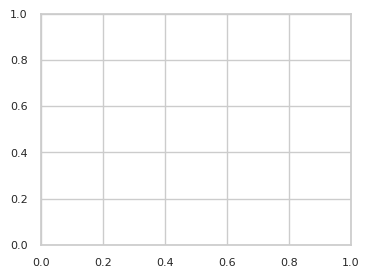

In [139]:
cases_scatter = cases.query(f"""year == 2018 & pct_following > 0.1 & pct_following < 2 & hiv_homo_pct_change_follow_year < 0.25 & hiv_homo > 20""")
sns.scatterplot(cases_scatter, x="pct_following", 
           y="hiv_homo_pct_change_follow_year", size="hiv_homo")
#,height=3, aspect=1.2
plt.show()

In [320]:
reg_data = cases.query(f"year in [2015,2016,2017,2018,2019]")

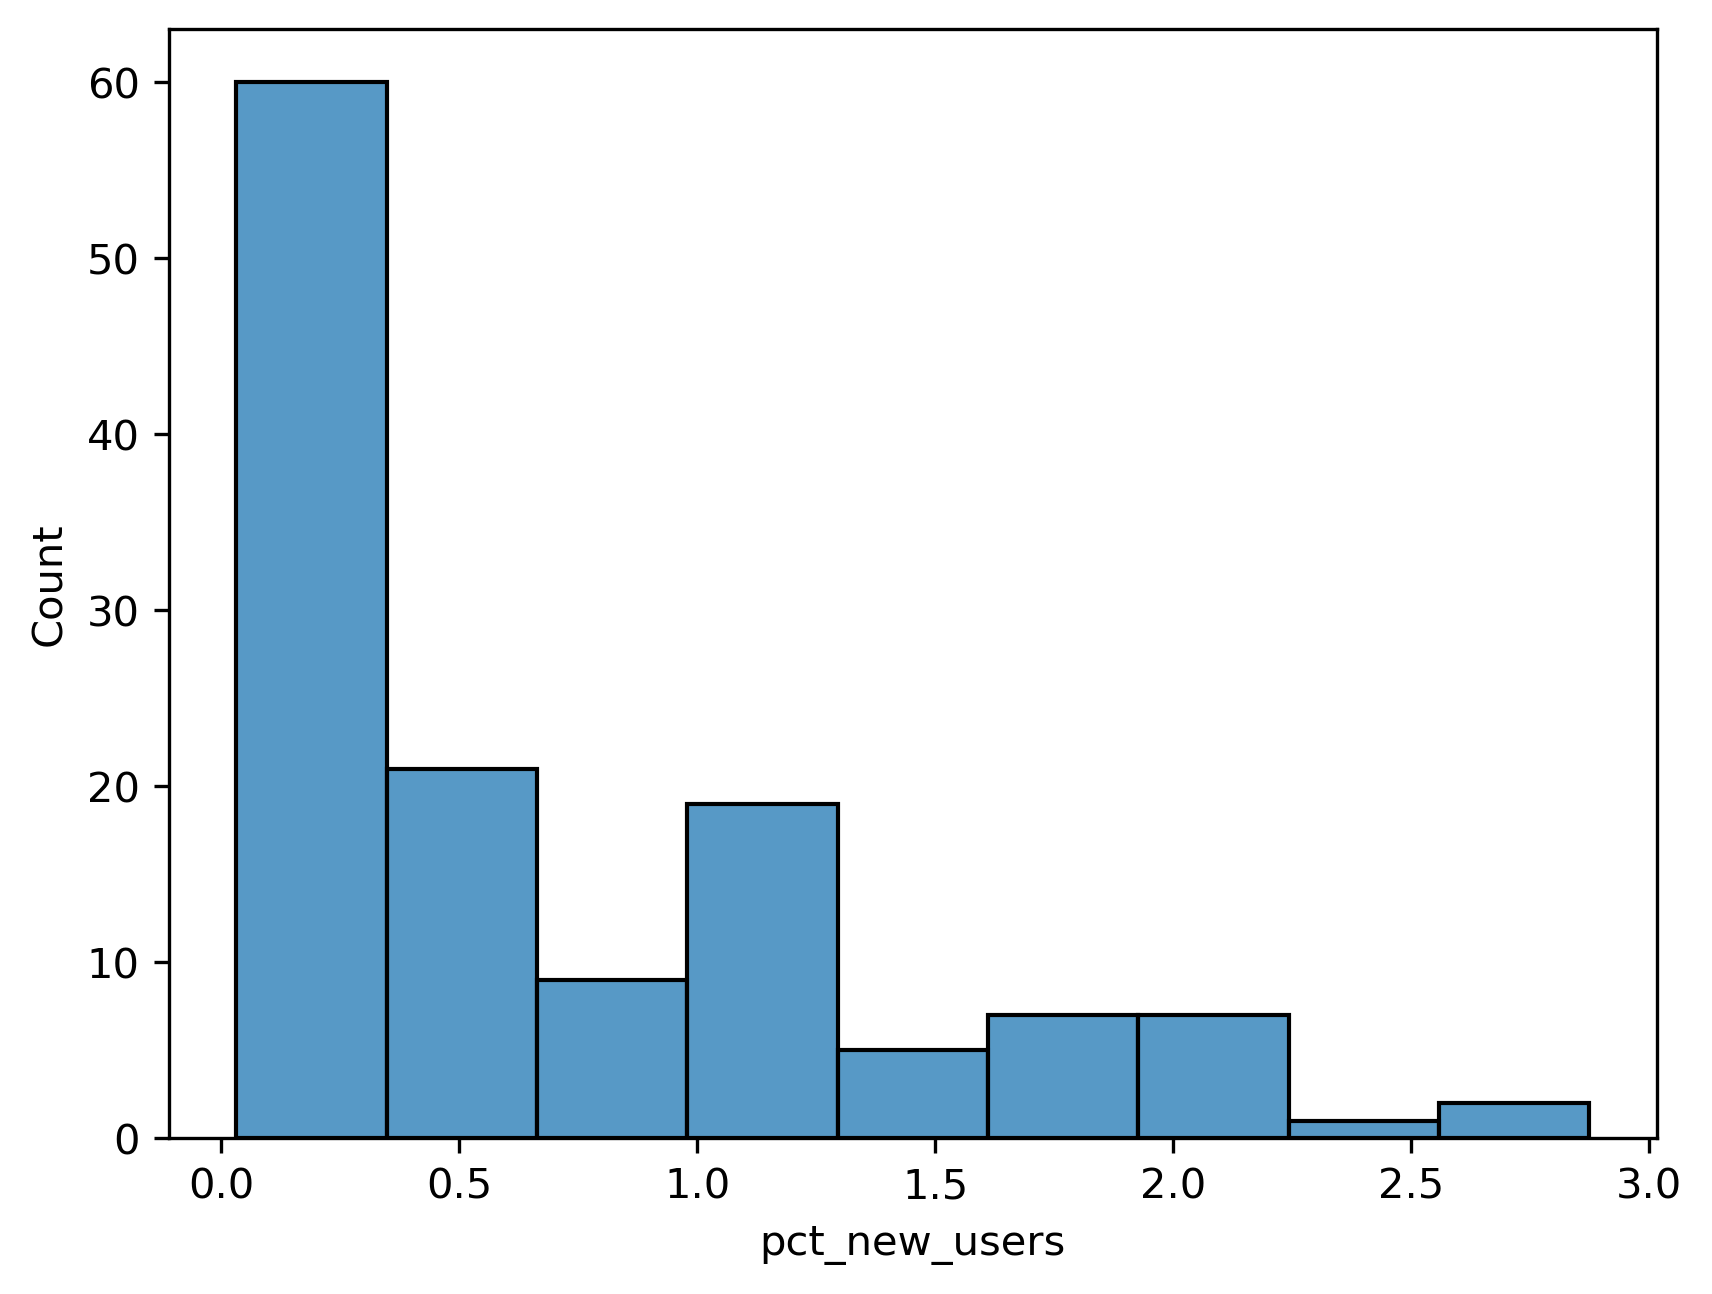

In [325]:
sns.histplot(cases.query("year == 2018 & pct_new_users > 0 & pct_new_users < 3"),
             x="pct_new_users")
plt.show()

#### regression 2: gay treated x gay non treated

In [ ]:
for index in top:
    sns.relplot(cases.loc[index], x="year", y="cases", kind="line",
                 errorbar=None, hue="group", col="city_name", col_wrap=1,
                 height=3, aspect=1.5)
    plt.axvline(2017, color="#b30059")
    plt.show()